# SETUP

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# # for rohit to run and connect to files
# %cd /content/drive/My Drive/FinalProject/data/preprocessed_data

# for nathan to run and connect to files
%cd /content/drive/My Drive/Gatech/Current Classes/CS7643/FinalProject/data/preprocessed_data

Mounted at /content/drive
/content/drive/My Drive/Gatech/Current Classes/CS7643/FinalProject/data/preprocessed_data


In [ ]:
!pip install TexSoup
!pip install sentencepiece

  Preparing metadata (setup.py) ... done
  Created wheel for TexSoup: filename=TexSoup-0.3.1-py3-none-any.whl size=27655 sha256=61240f957d2115d4d056ed949ecb12e4785f4a7880d117176bc22de0ee099cfc
  Stored in directory: /root/.cache/pip/wheels/e9/fe/38/33b1f404abc9f95703c51ac162115756458eb69906d0e6ac25
Successfully built TexSoup
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.2 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
import re
import os
import random
import tqdm
import pickle
import math
import TexSoup.tokens as t
import json
import ast
from transformers.models.nougat import NougatTokenizerFast
import sentencepiece
import sys
import torchvision.models as models

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# DATASET PREPROCESSING

In [ ]:
transform = transforms.Compose([
    transforms.Resize((1010, 1010)),
    transforms.ToTensor()
])

## Custom Dataset Class
Takes in image and annotation file paths, max_data_points (as lim), and the inage transform. Randomly shuffles the image–annotation pairings and selects only from the (1010 x 1010) images for consistency. We initially save the path to images, and utilize lazy loading, so in our get_item method we only load and transform images that we are looking at.

The output is in the form {'image': (3, 128, 128) RGB Image, 'text-content': Text}.

In [ ]:
class CustomDatasetLimited(Dataset):
    def __init__(self, input_folder, output_folder, lim, transform):
        self.input_folder = input_folder
        self.output_folder = output_folder
        self.transform = transform
        self.lim = lim
        self.data = self._load_data()
        self.transform = transform


    def _load_data(self):
        if self.lim is None:
          self.lim = 1600
        input_files = sorted(os.listdir(self.input_folder))
        output_files = sorted(os.listdir(self.output_folder))

        paired_files = list(zip(input_files, output_files))
        random.shuffle(paired_files)
        input_files, output_files = zip(*paired_files)

        data = []
        count = 0
        zip_files = list(zip(input_files, output_files))
        for i in tqdm.tqdm(range(len(zip_files))):
            img_file, txt_file = zip_files[i]
            if img_file.endswith('.png') and txt_file.endswith('.txt'):
                img_path = os.path.join(self.input_folder, img_file)
                txt_path = os.path.join(self.output_folder, txt_file)

                with open(txt_path, 'r') as file:
                    text_content = file.read()

                img = Image.open(img_path).convert('L')
                width, height = img.size
                if width == 1010 or height == 1010:
                  data.append({'image': img_path, 'text_content': text_content})
                  count += 1

            if count >= self.lim:
              return data

        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]['image']
        text_content = self.data[idx]['text_content']

        img = Image.open(image).convert('L')
        transformed_image = self.transform(img)

        return {'image': transformed_image, 'text_content': text_content}

In [ ]:
batch_size = 32

## Script that creates the dataset.
Option to limit dataset datapoints for testing purposes.

In [ ]:
# input_folder_path = 'train/IMG'
# output_folder_path = 'train/INKML'
# dataset = CustomDatasetLimited(input_folder_path, output_folder_path, lim=12024, transform=transform)
# batch_size = 32
# data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [ ]:
### Prints the number of batches per epoch ###

#print(len(dataset))

### Saves dataset to drive

In [ ]:

# with open('/content/drive/My Drive/Gatech/Current Classes/CS7643/FinalProject/dataset_full.pkl', 'wb') as f:
#     pickle.dump(dataset, f)

### For Loading in Pre-saved Dataset

In [ ]:
### NATHAN
with open('/content/drive/My Drive/Gatech/Current Classes/CS7643/FinalProject/dataset_full.pkl', 'rb') as f:
    loaded_dataset = pickle.load(f)

# # ## ROHIT
# with open('/content/drive/My Drive/FinalProject/dataset_1010_all.pkl', 'rb') as f:
#     loaded_dataset = pickle.load(f)

data_loader = DataLoader(loaded_dataset, batch_size=batch_size, shuffle=True)

### Debug for Image transform and dataset creation

In [ ]:
# for d in data_loader:
#   transform_resize = transforms.Resize((404, 404))
#   imgg = transform_resize(d['image'][31])
#   image_np = imgg.permute(1, 2, 0).cpu().numpy()
#   print(d['text_content'][31])

#   plt.imshow(image_np, cmap='gray')
#   plt.axis('off')
#   plt.show()
#   break


In [ ]:
print(len(data_loader))

298


# TOKENIZER

In [ ]:
# def tokenizer(equation):
#     # Tokenize LaTeX equation into individual symbols
#     tokens = re.findall(r'\w+|[\[\]{}()=+\-*/_,.]|\\[a-zA-Z]+|\\[^\s]+', equation)
#     return tokens

### This Tokenizer makes use of TexSoup, which is a regex based tokenizer for latex.

In [ ]:
def tokenizer(equation):
    toks = t.tokenize(t.categorize(equation))
    return list(toks)

In [ ]:
latex_equation = '$\\frac{1}{2} x^2 + \\sqrt{3}$'
tokens = tokenizer(latex_equation)
print(tokens)

['$', '\\', 'frac', '{', '1', '}', '{', '2', '}', ' x^2 + ', '\\', 'sqrt', '{', '3', '}', '$']


## Script to create word_to_idx, idx_to_word, word_counts, max_seq, and vocab_size variables.

In [ ]:
# tokens = []
# word_to_idx = {}
# idx_to_word = {}
# word_counts = {}

# word_to_idx[0] = "<BOS>"
# word_to_idx[1] = "<EOS>"
# word_to_idx[2] = "<PAD>"
# word_to_idx[3] = "<UNK>"

# idx_to_word['<BOS>'] = 0
# idx_to_word['<EOS>'] = 1
# idx_to_word['<PAD>'] = 2
# idx_to_word['<UNK>'] = 3

# idx = 4
# max_seq = 0

# for i, batch in tqdm.tqdm(enumerate(data_loader)):
#     annotation = batch['text_content']
#     for an in annotation:
#       toks = tokenizer(an)
#       if len(toks) > max_seq:
#         max_seq = len(toks)
#       for word in toks:
#           if word not in tokens:
#               word_to_idx[idx] = word
#               idx_to_word[word] = idx
#               word_counts[word] = 1
#               tokens.append(word)
#               idx += 1
#           else:
#               word_counts[word] += 1

# unique_tokens = set(tokens)

# ## Plus 1 for unknown token
# vocab_size = len(unique_tokens) + 4

# unk_token = 3
# pad_token = 2
# eos_token = 1
# bos_token = 0

# print(vocab_size)
# print(max_seq)

In [ ]:
# def tokenize(equation):
#     tokens = re.findall(r'\w+|[\[\]{}()=+\-*/_,.]|\\[a-zA-Z]+|\\[^\s]+', equation)
#     return [idx_to_word[index] if index in idx_to_word else idx_to_word["UNK"] for index in tokens]

In [ ]:
def tokenize(equation):
  toks = t.tokenize(t.categorize(equation))
  return [idx_to_word[index] if index in idx_to_word else idx_to_word["<UNK>"] for index in list(toks)]

In [ ]:
# print(tokenize('<BOS>\\frac{1}{2}<EOS>'))

In [ ]:
# print(word_to_idx)

In [ ]:
# print(idx_to_word)

In [ ]:
# print(word_counts)

In [ ]:
# print(len(word_to_idx))

In [ ]:
unk_token = 3
pad_token = 2
eos_token = 1
bos_token = 0

### Saves the tokenizer data to the tex_config json file.

In [ ]:
# with open('../../TexSoupTokenizer/word_to_idx.txt', 'w') as file:
#     file.write(str(word_to_idx))

# with open('../../TexSoupTokenizer/idx_to_word.txt', 'w') as file:
#     file.write(str(idx_to_word))

# with open('../../TexSoupTokenizer/word_counts.txt', 'w') as file:
#     file.write(str(word_counts))

### Loads in the saved tokenizer data from the tex_config json file.

In [ ]:
data = ""
with open('../../TexSoupTokenizer/word_to_idx.txt', 'r') as file:
  data = file.read()

try:
    word_to_idx = ast.literal_eval(data)
except (SyntaxError, ValueError) as e:
    print("Error occurred while converting to dictionary:", e)

data = ""
with open('../../TexSoupTokenizer/idx_to_word.txt', 'r') as file:
  data = file.read()

try:
    idx_to_word = ast.literal_eval(data)
except (SyntaxError, ValueError) as e:
    print("Error occurred while converting to dictionary:", e)

data = ""
with open('../../TexSoupTokenizer/word_counts.txt', 'r') as file:
  data = file.read()

try:
    word_counts = ast.literal_eval(data)
except (SyntaxError, ValueError) as e:
    print("Error occurred while converting to dictionary:", e)

In [ ]:
word_to_idx[10] = '\\'
print(word_to_idx[10])

\


In [ ]:
print(idx_to_word)

{'<BOS>': 0, '<EOS>': 1, '<PAD>': 2, '<UNK>': 3, '$': 4, 's = s_': 5, '{': 6, '0': 7, '}': 8, ' t + ': 9, '\\': 10, 'frac': 11, '1': 12, '2': 13, ' a ': 14, 't^': 15, ' 2 ': 16, ' ': 17, '3 m - 2 n ': 18, 'times': 19, ' 9^n - 9^m': 20, '2 n - 1': 21, 'sqrt': 22, '1 + ': 23, '2 + ': 24, '3 + ': 25, '4': 26, ' 1 + ': 27, ' 1 + z ^ 2 ': 28, 'sum': 29, '_': 30, 'i = 2 n + 3 m': 31, '^': 32, '1 0': 33, ' i x': 34, '_ ': 35, ' g ': 36, 'gt': 37, 'mbox': 38, ' R ': 39, '^ ': 40, ' r ': 41, ' u + ': 42, 'left': 43, '( ': 44, ' c ': 45, 'right': 46, ') ': 47, 'x_1 ': 48, ' x_2 ': 49, ' x_3 ': 50, ' x_4 = X': 51, 'h_': 52, 'k + q(k+1)': 53, '^2 - pk_': 54, '^2 = (-1)^': 55, 'q(k+1)': 56, 'a': 57, 'sin': 58, ' A': 59, ' = ': 60, 'b': 61, ' B': 62, 'c': 63, ' C': 64, ' r - ': 65, ' L ': 66, ' q ': 67, ' - i ': 68, ' w + v ': 69, 'n': 70, ' x^': 71, '( t ) = ': 72, '| X ( f ) |^': 73, 'b= c ': 74, ' B = c ': 75, 'cos': 76, 'x_': 77, ' + x_': 78, ' = x_': 79, '3': 80, '( y + 1 )^2 = y^2 + 2 y + 1': 

In [ ]:
vocab_size = len(word_to_idx)
max_seq = 185

In [ ]:
print(vocab_size, max_seq)

5759 185


In [ ]:
# tokenizr = NougatTokenizerFast.from_pretrained("Norm/nougat-latex-base")


In [ ]:
# latex_equation = '$s = s_{0} t + \\frac{1}{2} a {t^{2}}$'
# toks = tokenizr(latex_equation, add_special_tokens=False).input_ids
# print(toks)
# print(tokenizr.batch_decode(toks))

In [ ]:
# print(tokenizr.eos_token)

In [ ]:
# tokens_nougat = []
# word_to_idx_nougat = {}
# idx_to_word_nougat = {}
# word_counts_nougat = {}

# word_to_idx_nougat[0] = "<BOS>"
# word_to_idx_nougat[1] = "<EOS>"
# word_to_idx_nougat[2] = "<PAD>"
# word_to_idx_nougat[3] = "<UNK>"

# idx_to_word_nougat['<BOS>'] = 0
# idx_to_word_nougat['<EOS>'] = 1
# idx_to_word_nougat['<PAD>'] = 2
# idx_to_word_nougat['<UNK>'] = 3

# idx = 4
# max_seq = 0

# for i, batch in tqdm.tqdm(enumerate(data_loader)):
#     annotation = batch['text_content']
#     for an in annotation:
#       toks = tokenizr(an, add_special_tokens=False).input_ids
#       if len(toks) > max_seq:
#         max_seq = len(toks)
#       for word in toks:
#           if word not in tokens:
#               word_to_idx_nougat[idx] = word
#               idx_to_word_nougat[word] = idx
#               word_counts_nougat[word] = 1
#               tokens_nougat.append(word)
#               idx += 1
#           else:
#               word_counts_nougat[word] += 1

# unique_tokens = set(tokens_nougat)

# ## Plus 1 for unknown token
# vocab_size_nougat = len(unique_tokens) + 4

# unk_token = 3
# pad_token = 2
# eos_token = 1
# bos_token = 0

# print(vocab_size_nougat)
# print(max_seq)

# MODEL

1 Layer Normal LSTM

In [ ]:
# class EncoderCNN(nn.Module):
#     def __init__(self, embed_size):
#         super(EncoderCNN, self).__init__()
#         self.resnet = models.resnet50(pretrained=True)

#         self.resnet.fc = nn.Linear(in_features=2048, out_features=2048)

#         self.embed = nn.Linear(in_features=2048, out_features=embed_size)

#         self.relu = nn.ReLU()

#     def forward(self, x):
#         features = self.relu(self.resnet(x))
#         features = self.embed(features)
#         return features

# # Define Decoder LSTM
# class DecoderLSTM(nn.Module):
#     def __init__(self, embed_size, lstm_hidden_size, vocab_size):
#         super(DecoderLSTM, self).__init__()
#         self.hidden_size = lstm_hidden_size
#         self.embed_size = embed_size
#         self.vocab_size = vocab_size

#         self.lstm_cell = nn.LSTMCell(input_size=embed_size, hidden_size=lstm_hidden_size)

#         self.fc_out = nn.Linear(in_features=lstm_hidden_size, out_features=vocab_size)

#         self.embed = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_size)
#         self.initial_hidden_state = nn.Parameter(torch.zeros(1, lstm_hidden_size))
#         self.initial_cell_state = nn.Parameter(torch.zeros(1, lstm_hidden_size))

#     def forward(self, features, captions):
#         batch_size = features.size(0)

#         hidden_state = self.initial_hidden_state.expand(batch_size, -1)
#         cell_state = self.initial_cell_state.expand(batch_size, -1)

#         outputs = torch.empty((batch_size, captions.size(1), self.vocab_size)).cuda()

#         captions_embed = self.embed(captions)

#         for i in range(captions.size(1)):
#             if i == 0:
#                 hidden_state, cell_state = self.lstm_cell(features, (hidden_state, cell_state))
#             else:
#                 hidden_state, cell_state = self.lstm_cell(captions_embed[:, i - 1, :], (hidden_state, cell_state))

#             out = self.fc_out(hidden_state)

#             outputs[:, i, :] = out

#         return outputs

In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        self.resnet = models.resnet50(weights = models.resnet.ResNet50_Weights.DEFAULT)

        ## Converts resnet to take in grayscale 1 channel
        self.resnet.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.resnet.fc = nn.Linear(in_features=2048, out_features=2000)
        self.embed = nn.Linear(in_features=2000, out_features=embed_size)

        self.silu = nn.SiLU()

    def forward(self, x):
        features = self.silu(self.resnet(x))
        features = self.embed(features)
        return features

# Define Decoder LSTM
class DecoderLSTM(nn.Module):
    def __init__(self, embed_size, lstm_hidden_size, vocab_size):
        super(DecoderLSTM, self).__init__()
        self.hidden_size = lstm_hidden_size
        self.embed_size = embed_size
        self.vocab_size = vocab_size

        self.lstm = nn.LSTM(input_size=embed_size, hidden_size=lstm_hidden_size,
                      num_layers=1,
                      bias=True,
                      batch_first=True,
                      dropout=0,
                      bidirectional=False,
        )
        self.dropout = nn.Dropout(0.2)

        self.fc_out = nn.Linear(in_features=lstm_hidden_size, out_features=vocab_size)
        self.embed = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_size)
        self.initial_hidden_state = nn.Parameter(torch.zeros(1, batch_size, self.hidden_size)).to(device)
        self.initial_cell_state = nn.Parameter(torch.zeros(1, batch_size, self.hidden_size)).to(device)


    def forward(self, features, captions):
        ## Captions should come in without any EOS to prevent prediction of such

        batch_size = captions.shape[0]
        self.initial_hidden_state = nn.Parameter(torch.zeros(1, batch_size, self.hidden_size)).to(device)
        self.initial_cell_state = nn.Parameter(torch.zeros(1, batch_size, self.hidden_size)).to(device)
        embeddings = self.embed(captions) # (batch_size, captions length - 1, embed_size)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), dim=1) # (batch_size, caption length, embed_size)

        out, self.hidden = self.lstm(embeddings, (self.initial_hidden_state, self.initial_cell_state)) # (batch_size, caption length, hidden_size)
        out = self.dropout(out)
        outputs = self.fc_out(out) # (batch_size, caption length, vocab_size)

        return outputs



## If we had more time, we should train this Bidirectional LSTM Decoder.
Curious to see if learning context from both past and future tokens will help us generate LaTeX that is more semantically correct on a LOCAL level (\frac{1}{\sqrt{2}} grouped blocks for example). Long term however, LaTex will be sequential in nature, so regular LSTM might be best.

In [ ]:
# # Define Decoder LSTM
# class DecoderLSTM(nn.Module):
#     def __init__(self, embed_size, lstm_hidden_size, vocab_size):
#         super(DecoderLSTM, self).__init__()
#         self.hidden_size = lstm_hidden_size
#         self.embed_size = embed_size
#         self.vocab_size = vocab_size

#         self.lstm = nn.LSTM(input_size=embed_size, hidden_size=lstm_hidden_size // 2,
#                       num_layers=1,
#                       bias=True,
#                       batch_first=True,
#                       dropout=0.2,
#                       bidirectional=True,
#         )

#         self.fc_out = nn.Linear(in_features=lstm_hidden_size, out_features=vocab_size)
#         self.embed = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_size)
#         self.initial_hidden_state = nn.Parameter(torch.zeros(2, batch_size, self.hidden_size//2)).to(device)
#         self.initial_cell_state = nn.Parameter(torch.zeros(2, batch_size, self.hidden_size//2)).to(device)


#     def forward(self, features, captions):
#         ## Captions should come in without any EOS to prevent prediction of such

#         batch_size = captions.shape[0]
#         self.initial_hidden_state = nn.Parameter(torch.zeros(2, batch_size, self.hidden_size//2)).to(device)
#         self.initial_cell_state = nn.Parameter(torch.zeros(2, batch_size, self.hidden_size//2)).to(device)
#         embeddings = self.embed(captions) # (batch_size, captions length - 1, embed_size)
#         embeddings = torch.cat((features.unsqueeze(1), embeddings), dim=1) # (batch_size, caption length, embed_size)

#         out, self.hidden = self.lstm(embeddings, (self.initial_hidden_state, self.initial_cell_state)) # (batch_size, caption length, hidden_size)
#         outputs = self.fc_out(out) # (batch_size, caption length, vocab_size)

#         return outputs

# TRAINING

### First attempt at reweighting CrossEntropy for initial tokenizer imbalance.

In [ ]:
# weights = torch.ones(your_vocab_size).to("cpu")
# total_tokens = sum(word_counts.values()) + 9511

# weights_dict = {token: total_tokens / count for token, count in word_counts.items()}

# # Assign weights to the weights tensor
# for idx, (token, _) in enumerate(weights_dict.items()):
#     weights[idx + 4] = weights_dict[token]

# weights[eos_token] = total_tokens / 9511

# # Normalize weights to sum up to 1 (optional)
# weights /= weights.sum()

# print(weights.sum())

### Displays sorted imbalance in token counts for Our Old Tokenizer.

In [ ]:
data = ""
with open('../../old_tokenizer/word_counts.txt', 'r') as f:
  data = f.read()

try:
    old_word_counts = ast.literal_eval(data)
except (SyntaxError, ValueError) as e:
    print("Error occurred while converting to dictionary:", e)

data = ""
with open('../../old_tokenizer/idx_to_word.txt', 'r') as f:
  data = f.read()

try:
    old_idx_to_word = ast.literal_eval(data)
except (SyntaxError, ValueError) as e:
    print("Error occurred while converting to dictionary:", e)

data = ""
with open('../../old_tokenizer/word_to_idx.txt', 'r') as f:
  data = f.read()

try:
    old_word_to_idx = ast.literal_eval(data)
except (SyntaxError, ValueError) as e:
    print("Error occurred while converting to dictionary:", e)

In [ ]:
sorted_weights = dict(sorted(old_word_counts.items(), key= lambda x: x[1], reverse=True))
top_20 = 0
for key, value in sorted_weights.items():
  print(key, value, old_idx_to_word[key])
  top_20 += 1
  if top_20 >= 20:
    break


} 21777 9
{ 21776 7
+ 5904 11
2 5379 14
- 4592 18
1 4503 13
x 4393 28
\frac 4266 12
( 4135 36
) 4135 39
= 3816 5
n 2156 19
\sqrt 2032 22
3 1874 16
\mbox 1845 31
a 1815 15
_ 1733 26
y 1638 60
b 1407 51
4 1061 23


Displays sorted imbalance in token counts for TexSoup Tokenizer.

In [ ]:
sorted_weights = dict(sorted(word_counts.items(), key= lambda x: x[1], reverse=True))
top_20 = 0
for key, value in sorted_weights.items():
  print(key, value, idx_to_word[key])
  top_20 += 1
  if top_20 >= 20:
    break


{ 21794 6
} 21772 8
\ 19693 10
  17988 17
$ 10504 4
frac 4269 11
sqrt 2032 22
2 1882 13
mbox 1845 38
1 1219 12
_ 1108 30
sin 968 58
^ 730 32
sum 710 29
cos 709 76
int 708 150
left 670 43
n 670 70
right 669 46
theta 582 218


The first 11 entries printed:
Token, Count, Index

In [ ]:
# } 21777 9
# { 21776 7
# + 5904 11
# 2 5379 14
# - 4592 18
# 1 4503 13
# x 4393 28
# \frac 4266 12
# ( 4135 36
# ) 4135 39
# = 3816 5

### Second attempt to manually add weights for CrossEntropy based on prints above.

In [ ]:
weights = torch.ones(vocab_size).to(device)
weights[pad_token] = 0.0
weights[bos_token] = 1.0
weights[unk_token] = 0.4
weights[eos_token] = 1.0


weights[7] = 0.07
weights[9] = 0.07
weights[11] = 0.25
weights[14] = 0.25
weights[22] = 0.3
weights[18] = 0.3
weights[1] = 0.3
weights[28] = 0.35
weights[12] = 0.4
weights[36] = 0.45
weights[39] = 0.45
weights[5] = 0.5

weights /= weights.sum()


### TexSoup Tokenizer weights

In [ ]:
# { 21794 6
# } 21772 8
# \ 19693 10
#   17988 17
# $ 10504 4
# frac 4269 11
# sqrt 2032 22
# 2 1882 13
# mbox 1845 38

weights = torch.ones(vocab_size).to(device)
weights[pad_token] = 0.0
weights[bos_token] = 1.0
weights[unk_token] = 0.2
weights[eos_token] = 1.0


weights[6] = 0.8
weights[8] = 0.8
weights[10] = 0.9
weights[17] = 0.9
weights[4] = 0.95
weights[11] = 0.95
weights[22] = 0.95
weights[13] = 0.97
weights[38] = 0.897

weights /= weights.sum()

In [ ]:
print(weights[0:15])

tensor([1.7372e-04, 1.7372e-04, 0.0000e+00, 3.4744e-05, 1.6504e-04, 1.7372e-04,
        1.3898e-04, 1.7372e-04, 1.3898e-04, 1.7372e-04, 1.5635e-04, 1.6504e-04,
        1.7372e-04, 1.6851e-04, 1.7372e-04], device='cuda:0')


In [ ]:
weights.to(device)

tensor([0.0002, 0.0002, 0.0000,  ..., 0.0002, 0.0002, 0.0002], device='cuda:0')

### Plots a bar graph for each token and the distribution of how many times each appears with the first tokenizer.

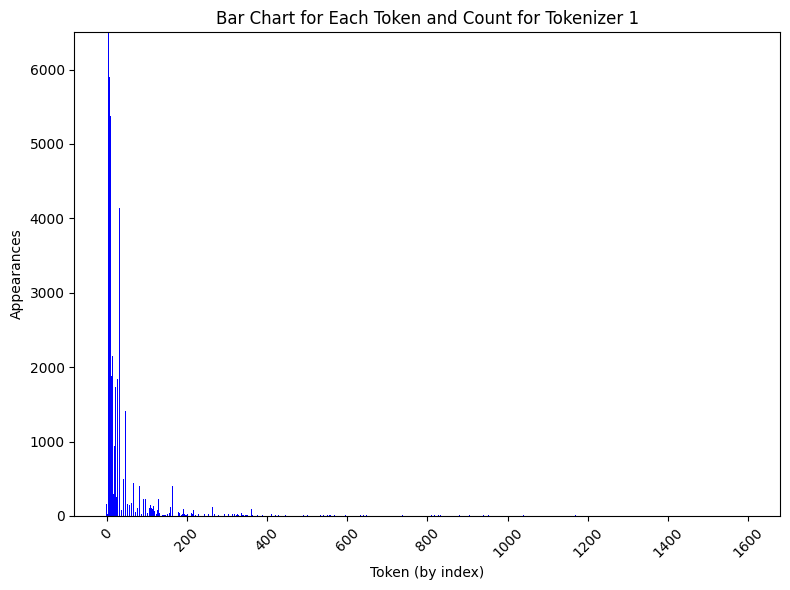

In [ ]:
keyss = list(old_word_counts.keys())
values = list(old_word_counts.values())

# Create a bar chart for each key-value pair
plt.figure(figsize=(8, 6))
plt.bar(range(len(keyss)), values, color='blue')
plt.xlabel('Token (by index)')
plt.ylabel('Appearances')
plt.title('Bar Chart for Each Token and Count for Tokenizer 1')
plt.ylim(0,6_500)
plt.xticks(rotation=45)
plt.tight_layout()

### Now, the same plot but for the TexSoup Tokenizer.

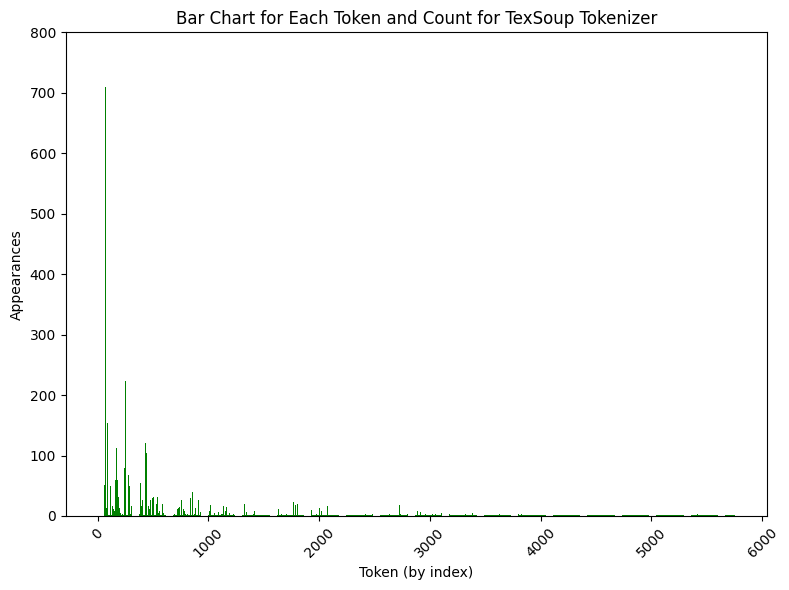

In [ ]:
keyss = list(word_counts.keys())
values = list(word_counts.values())

# Create a bar chart for each key-value pair
plt.figure(figsize=(8, 6))
plt.bar(range(len(keyss)), values, color='green')
plt.xlabel('Token (by index)')
plt.ylabel('Appearances')
plt.title('Bar Chart for Each Token and Count for TexSoup Tokenizer')
plt.ylim(0,800)
plt.xticks(rotation=45)
plt.tight_layout()

## Original Model Training
Saved as encoder_sb/decoder_sb pth.
Issue with generations only resulting in same sequences. This means that our model may not learn well or there is an error with the training and padding.

In [ ]:
# # Hyperparameters and other settings
# batch_size = 32
# learning_rate = 0.0005
# num_epochs = 2
# embed_size = 1024
# hidden_size = 1024


# # Instantiate Encoder and Decoder models
# encoder = EncoderCNN(embed_size=embed_size).to('cuda')
# decoder = DecoderLSTM(embed_size=embed_size, lstm_hidden_size=hidden_size, vocab_size=vocab_size).to('cuda')

# # Define Loss and Optimizer



# criterion = nn.CrossEntropyLoss(weight=weights, ignore_index=pad_token)
# params = list(encoder.parameters()) + list(decoder.parameters())
# optimizer = torch.optim.Adam(params, lr=learning_rate)

# # Training loop
# encoder.train()
# decoder.train()

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)

# special_tokens = [eos_token, pad_token]

# for epoch in range(num_epochs):
#     for i, batch in enumerate(data_loader):
#       optimizer.zero_grad()

#       images = batch["image"]
#       batch_images = images.to(device)

#       annotations = batch["text_content"]

#       latex = [tokenize(caption) for caption in annotations]
#       # captions_list = [[bos_token] + caption + [pad_token] * (max_seq - len(caption) - 1) for caption in latex]
#       # captions_list_shifted = [[bos_token] + caption + [eos_token] + [pad_token] * (max_seq - len(caption) - 2) for caption in latex]

#       captions_list = [[bos_token] + caption + [eos_token] + [pad_token] * (max_seq - len(caption) - 2) for caption in latex]
#       captions_list_shifted = [[bos_token] + [bos_token] + caption + [eos_token] + [pad_token] * (max_seq - len(caption) - 3) for caption in latex]

#       # captions_list = [[bos_token] + caption + [pad_token] * (max_seq - len(caption) - 1) for caption in latex]
#       # captions_list_shifted = [[bos_token] + [bos_token] + caption + [eos_token] + [pad_token] * (max_seq - len(caption) - 3) for caption in latex]

#       captions_target = torch.tensor(captions_list_shifted).to(device)
#       captions_train = torch.tensor(captions_list).to(device)

#       # captions_target = captions_target.to(device)
#       # captions_train = captions_train.to(device)


#       # Forward pass
#       features = encoder(batch_images).to(device)
#       outputs = decoder(features, captions_train[:, :-1]).to(device)  # Exclude the last token for input

#       # eos_mask = (captions_target == eos_token).to(device)
#       # captions_target_masked = captions_target.masked_fill(eos_mask, pad_token).to(device)

#       out = outputs.view(-1, vocab_size).to(device)
#       cap = captions_target[:, 1:].contiguous().view(-1).to(device)

#       loss = criterion(out, cap).to(device)

#       # Backward pass and optimization
#       loss.backward()
#       optimizer.step()
#       if (i % 8 == 0):
#         print(f"Batch Number [{i}], Loss: {loss.item()}")
#         caption_words = [word_to_idx[idx.item()] for idx in list(captions_target[0])]
#         print("Captions Target: ", ''.join(caption_words))
#         predicted_words = outputs.argmax(2)
#         predicted_words = [word_to_idx[idx.item()] for idx in list(predicted_words[0])]
#         print("Predicted caption:", ''.join(predicted_words))

#     print(f"Epoch [{epoch+1}/{num_epochs}] complete, Loss: {loss.item()}")

# # Save the trained models
# torch.save(encoder.state_dict(), 'encoder_sb.pth')
# torch.save(decoder.state_dict(), 'decoder_sb.pth')

## NEW Model Training (V1)
First one is saved as encoder/decoder pth.
Second one will be saved as encoder_v2/decoder_v2 pth.

In [ ]:
# # Hyperparameters and other settings
# batch_size = 32
# learning_rate = 0.00005
# num_epochs = 5
# embed_size = 1024
# hidden_size = 1024


# # Instantiate Encoder and Decoder models
# encoder = EncoderCNN(embed_size=embed_size).to('cpu')
# decoder = DecoderLSTM(embed_size=embed_size, lstm_hidden_size=hidden_size, vocab_size=vocab_size).to('cpu')

# # Define Loss and Optimizer



# criterion = nn.CrossEntropyLoss(weight=weights, ignore_index=pad_token)
# params = list(encoder.parameters()) + list(decoder.parameters())
# optimizer = torch.optim.Adam(params, lr=learning_rate)

# # Training loop
# encoder.train()
# decoder.train()

# device = torch.device("cpu" if torch.cuda.is_available() else "cpu")
# print(device)

# special_tokens = [eos_token, pad_token]

# for epoch in range(num_epochs):
#     for i, batch in enumerate(data_loader):
#       optimizer.zero_grad()

#       images = batch["image"]
#       batch_images = images.to(device)

#       annotations = batch["text_content"]

#       latex = [tokenize(caption) for caption in annotations]
#       # captions_list = [[bos_token] + caption + [pad_token] * (max_seq - len(caption) - 1) for caption in latex]
#       # captions_list_shifted = [[bos_token] + caption + [eos_token] + [pad_token] * (max_seq - len(caption) - 2) for caption in latex]

#       captions_list = [[bos_token] + caption + [pad_token] * (max_seq - len(caption) - 1) for caption in latex]
#       captions_list_shifted = [caption + [eos_token] + [pad_token] * (max_seq - len(caption) - 1) for caption in latex]

#       # captions_list = [[bos_token] + caption + [pad_token] * (max_seq - len(caption) - 1) for caption in latex]
#       # captions_list_shifted = [[bos_token] + [bos_token] + caption + [eos_token] + [pad_token] * (max_seq - len(caption) - 3) for caption in latex]

#       captions_target = torch.tensor(captions_list_shifted).to(device)
#       captions_train = torch.tensor(captions_list).to(device)

#       # captions_target = captions_target.to(device)
#       # captions_train = captions_train.to(device)


#       # Forward pass
#       features = encoder(batch_images).to(device)
#       outputs = decoder(features, captions_train).to(device)  # Exclude the last token for input

#       # eos_mask = (captions_target == eos_token).to(device)
#       # captions_target_masked = captions_target.masked_fill(eos_mask, pad_token).to(device)

#       out = outputs.view(-1, vocab_size).to(device)
#       cap = captions_target.contiguous().view(-1).to(device)

#       loss = criterion(out, cap).to(device)

#       # Backward pass and optimization
#       loss.backward()
#       optimizer.step()
#       if (i % 8 == 0):
#         print(f"Batch Number [{i}], Loss: {loss.item()}")
#         caption_words = [word_to_idx[idx.item()] for idx in list(captions_target[0])]
#         print("Captions Target: ", ''.join(caption_words))
#         predicted_words = outputs.argmax(2)
#         predicted_words = [word_to_idx[idx.item()] for idx in list(predicted_words[0])]
#         print("Predicted caption:", ''.join(predicted_words))
#         print()

#     print(f"Epoch [{epoch+1}/{num_epochs}] complete, Loss: {loss.item()}")

# # Save the trained models
# torch.save(encoder.state_dict(), 'encoder.pth')
# torch.save(decoder.state_dict(), 'decoder.pth')

## V2, V4 Model Training

In [ ]:
# Hyperparameters and other settings
batch_size = 32
learning_rate = 0.0005
num_epochs = 10
embed_size = 164
hidden_size = 450

# Instantiate Encoder and Decoder models
encoder = EncoderCNN(embed_size=embed_size).to(device)
decoder = DecoderLSTM(embed_size=embed_size, lstm_hidden_size=hidden_size, vocab_size=vocab_size).to(device)

# Define Loss and Optimizer



criterion = nn.CrossEntropyLoss(ignore_index=pad_token)
params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = torch.optim.Adam(params, lr=learning_rate, weight_decay=1e-5)

# Training loop
encoder.train()
decoder.train()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


for epoch in range(num_epochs):
    for i, batch in enumerate(data_loader):
      decoder.zero_grad()
      encoder.zero_grad()

      images = batch["image"]
      transform_resize = transforms.Resize((404, 404), antialias=True)
      resized_images = torch.stack([transform_resize(image) for image in images])

      batch_images = resized_images.to(device)

      annotations = batch["text_content"]

      latex = [tokenize(caption) for caption in annotations]
      captions_list = [[bos_token] + caption + [pad_token] * (max_seq - len(caption) - 2) for caption in latex]
      captions_list_shifted = [[bos_token] + caption + [eos_token] + [pad_token] * (max_seq - len(caption) - 2) for caption in latex]

      captions = torch.tensor(captions_list).to(device)
      captions_target = torch.tensor(captions_list_shifted).to(device)

      # Forward pass
      features = encoder(batch_images).to(device)
      outputs = decoder(features, captions).to(device)  # Exclude the last token for input

      # eos_mask = (captions_target == eos_token).to(device)
      # captions_target_masked = captions_target.masked_fill(eos_mask, pad_token).to(device)

      out = outputs.contiguous().view(-1, vocab_size).to(device)
      cap = captions_target.view(-1).to(device)
      loss = criterion(out, cap).to(device)

      # Backward pass and optimization
      loss.backward()
      optimizer.step()
      if i % 16 == 0:
        print(f"Batch Number [{i}], Loss: {loss.item()}")
      if i % 32 == 0:
        caption_words = [word_to_idx[idx.item()] for idx in list(captions_target[0])]
        print("Captions Target: ", ''.join(caption_words))
        predicted_words = outputs.argmax(2)
        predicted_words = [word_to_idx[idx.item()] for idx in list(predicted_words[0])]
        print("Predicted caption:", ''.join(predicted_words))
        print()

    print(f"Epoch [{epoch+1}/{num_epochs}] complete, Loss: {loss.item()}")

# Save the trained models
torch.save(encoder.state_dict(), 'encoder_v4.pth')
torch.save(decoder.state_dict(), 'decoder_v4.pth')

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 172MB/s]


cuda
Batch Number [0], Loss: 8.655673027038574
Captions Target:  <BOS>$\sigma(0)=01$<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
Predicted caption: i

In [ ]:
# pad_token = tokenizr.pad_token_id
# bos_token = tokenizr.bos_token_id
# eos_token = tokenizr.eos_token_id
# print(pad_token, bos_token, eos_token)

In [ ]:
# vocab_size = len(tokenizr)
# max_seq = 185

# EVALUATION

### For Loading Trained Models

In [ ]:
encoder_model = EncoderCNN(164) # Change this to match
encoder_state = torch.load('encoder_v4.pth', map_location=torch.device('cuda'))
encoder_model.load_state_dict(encoder_state)

decoder_model = DecoderLSTM(164, 450, vocab_size) ## Change this to match
decoder_state = torch.load('decoder_v4.pth', map_location=torch.device('cuda'))
decoder_model.load_state_dict(decoder_state)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 185MB/s]


<All keys matched successfully>

In [ ]:
image_path = 'train/IMG/image_8.png'

In [ ]:
img = Image.open(image_path)

In [ ]:
encoded_image = img.convert('L')
encoded_image = transform(encoded_image)
trans = transforms.Resize((404,404), antialias=True)
encoded_image = trans(encoded_image)

In [ ]:
encoded_image_print = img.convert('RGB')
encoded_image_print = transform(encoded_image_print)
trans = transforms.Resize((404,404), antialias=True)
encoded_image_print = trans(encoded_image_print)

For visualization of the image.

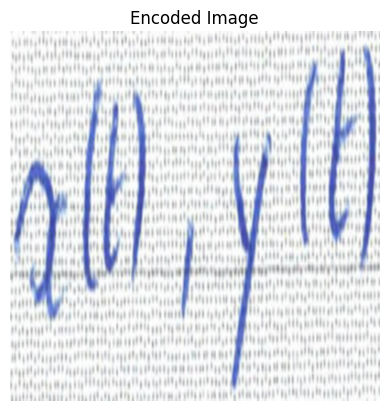

In [ ]:
encoded_image_test = encoded_image_print.unsqueeze(0)

encoded_image_np = encoded_image_print.squeeze(0).permute(1, 2, 0).numpy()

plt.imshow(encoded_image_np)
plt.axis('off')
plt.title('Encoded Image')
plt.show()


In [ ]:
encoded_image = encoded_image.to(device)
encoder_model = encoder_model.to(device)
decoder_model = decoder_model.to(device)

In [ ]:
# After training, for prediction:

# Load your test dataset (or new unseen images)
# Preprocess the test images (transform them similar to training)

# Set models to evaluation mode
encoder_model = encoder_model.to(device)
decoder_model = decoder_model.to(device)
encoder_model.eval()
decoder_model.eval()



with torch.no_grad():
    for image in [encoded_image]:
        image_tensor = image.unsqueeze(0)
        features = encoder_model(image_tensor.to(device))

        # Initialize caption with start token
        caption = torch.tensor([[bos_token]]).to(device)
        predicted_caption = []

        for i in range(0, max_seq):
            output = decoder_model(features, caption)
            predicted_index = output.argmax(2)[:,-1].unsqueeze(1)

            caption = torch.cat((caption, predicted_index), dim=1)

            if predicted_index.item() == eos_token or predicted_index.item() == pad_token:  # Replace end_token_index with your end token index
                break

        # print(caption)
        predicted_words = [word_to_idx[idx.item()] for idx in caption[0]]
        print("Predicted caption:", ''.join(predicted_words))



### ROUGE accuracy loop

In [ ]:
!pip install rouge

In [ ]:
from rouge import Rouge

[[{'rouge-1': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.0, 'p': 0.0, 'f': 0.0}}], [{'rouge-1': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.0, 'p': 0.0, 'f': 0.0}}], [{'rouge-1': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.0, 'p': 0.0, 'f': 0.0}}], [{'rouge-1': {'r': 0.3333333333333333, 'p': 0.06666666666666667, 'f': 0.1111111083333334}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.3333333333333333, 'p': 0.06666666666666667, 'f': 0.1111111083333334}}], [{'rouge-1': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.0, 'p': 0.0, 'f': 0.0}}], [{'rouge-1': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.0, 'p': 0.0, 'f': 0.0}}], [{'rouge-1': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.0,

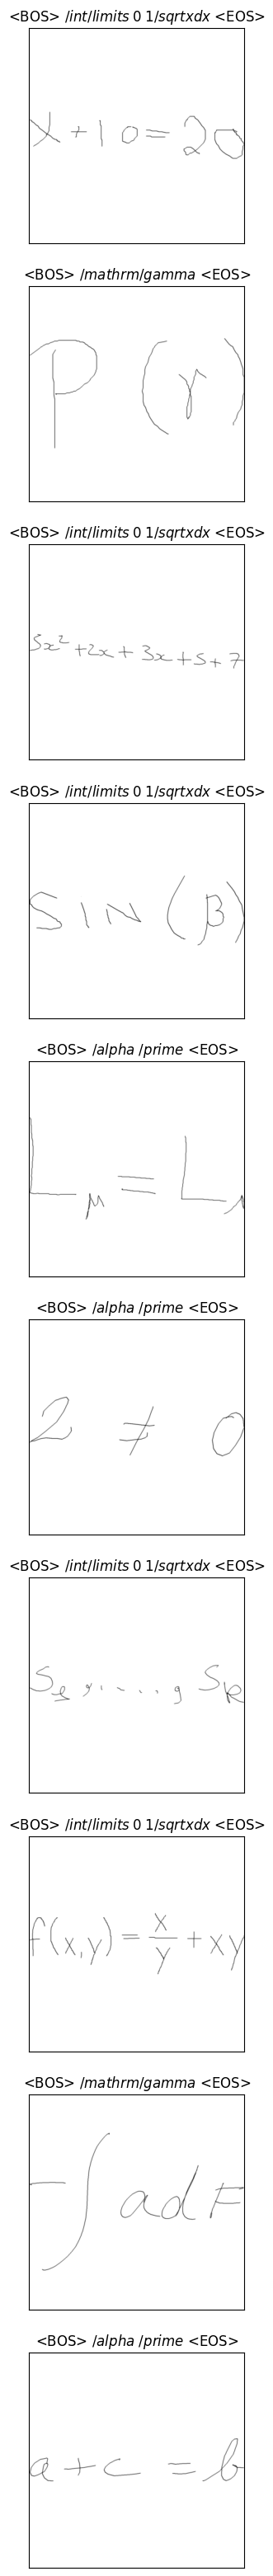

In [ ]:
# After training, for prediction:

# Load your test dataset (or new unseen images)
# Preprocess the test images (transform them similar to training)

# Set models to evaluation mode
encoder_model.eval()
decoder_model.eval()

count = 0

num_images = 10
fig, axs = plt.subplots(num_images, 1, figsize=(4, 4*num_images))


rouge = Rouge()
scores = []

with torch.no_grad():
    for d in data_loader:

        txt = d['text_content'][6]

        img = d['image'][6]
        trans = transforms.Resize((404,404), antialias=True)
        encoded_image = trans(img)
        image_tensor = encoded_image.unsqueeze(0)
        features = encoder_model(image_tensor.to(device))

        # Initialize caption with start token
        caption = torch.tensor([[bos_token]]).to(device)
        predicted_caption = []

        for i in range(0, max_seq):
            output = decoder_model(features, caption)
            predicted_index = output.argmax(2)[:,-1].unsqueeze(1)

            caption = torch.cat((caption, predicted_index), dim=1)

            if predicted_index.item() == eos_token or predicted_index.item() == pad_token:  # Replace end_token_index with your end token index
                break

        # print(caption)
        predicted_words = [word_to_idx[idx.item()] for idx in caption[0]]
        # print("Predicted caption:", ''.join(predicted_words))

        image_np = encoded_image.permute(1, 2, 0).cpu().numpy()
        predicted_cap = ' '.join(predicted_words)
        scores.append(rouge.get_scores(predicted_cap, txt))
        predicted_cap = predicted_cap.replace('\\', '/')
        axs[count].set_title(predicted_cap)
        axs[count].set_xticks([])
        axs[count].set_yticks([])
        axs[count].imshow(image_np, cmap='gray')

        count += 1
        if count == num_images:
          break

print(scores)

In [ ]:
plt.tight_layout()  # Adjust layout
plt.show()

## Generation loop attempt 2, works the same way as Attempt 1.

In [ ]:
encoder_model.eval()
decoder_model.eval()

with torch.no_grad():
  feature = encoder_model(encoded_image.reshape(1, encoded_image.size(0), encoded_image.size(1), encoded_image.size(2)))

  sampled_ids = []
  inputs = torch.tensor([[bos_token]]).to(device)

  for i in range(max_seq):
      outputs = decoder_model(feature, inputs)
      _, predicted = outputs.max(2)
      predicted = predicted[-1]
      sampled_ids.append(predicted.item())
      inputs = torch.cat((inputs, torch.tensor([[predicted]])), dim=0)


      if predicted.item() == eos_token:
          break

  sampled_ids = [word_to_idx[idx] for idx in sampled_ids]
  sentence = ''.join(sampled_ids)
print(sentence)